In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from catboost import CatBoostClassifier
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score

import random

random.seed(179)
np.random.seed(179)

In [2]:
train = pd.read_pickle('../data/preprocessed/train_dedup.pkl')
test = pd.read_pickle('../data/preprocessed/test_dedup.pkl')

In [5]:
# all_cols = set(test.columns.tolist())
# dedup_cols = set(test.T.drop_duplicates().index.tolist())
# duplicated_cols = list(all_cols - dedup_cols)

# train = train.drop(duplicated_cols, axis=1)
# test = test.drop(duplicated_cols, axis=1)

# train.to_pickle('../data/preprocessed/train_rolling_dedup.pkl')
# test.to_pickle('../data/preprocessed/test_rolling_dedup.pkl')

In [3]:
# month как категория
train['MONTH(date)'] = train['MONTH(date)'].astype('category')
test['MONTH(date)'] = test['MONTH(date)'].astype('category')

train = train.drop('YEAR(date)', axis=1)
test = test.drop('YEAR(date)', axis=1)

In [4]:
# скользящая валидация
folds = [
    train[train['date'] <= '2016-08-01'].copy(),
    train[(train['date'] > '2016-08-01') & (train['date'] <= '2017-08-01')].copy(),
    train[(train['date'] > '2017-08-01') & (train['date'] <= '2018-08-01')].copy(),
    train[(train['date'] > '2018-08-01') & (train['date'] <= '2019-08-01')].copy(),
]

In [5]:
cv_metrics = {
    'AP': [],
    'ROC-AUC': [],
}
for idx in tqdm(range(3), desc='Folds'):
    fold_train = pd.concat(folds[:idx + 1])
    fold_val = folds[idx + 1].copy()

    y_train = fold_train['sick']
    X_train = fold_train.drop(['date', 'cutoff_date', 'sick', 'hash_tab_num'], axis=1)
    y_val = fold_val['sick']
    X_val = fold_val.drop(['date', 'cutoff_date', 'sick', 'hash_tab_num'], axis=1)
    
    cat_col_names = X_train.select_dtypes('category').columns.tolist()
    cat_features = [idx for idx, col in enumerate(X_train.columns) if col in cat_col_names]

    clf = CatBoostClassifier(
        iterations=1000,
        random_seed=179,
        task_type='GPU',
        auto_class_weights='Balanced',
        bootstrap_type='Bayesian',
        bagging_temperature=3,
        min_data_in_leaf=5,
    )
    
    clf.fit(X_train, y_train, cat_features=cat_features, verbose=250, eval_set=(X_val, y_val), use_best_model=True)
    y_probs = clf.predict_proba(X_val)[:, 1]
    
    ap = average_precision_score(y_val, y_probs)
    cv_metrics['AP'].append(ap)
    roc_auc = roc_auc_score(y_val, y_probs)
    cv_metrics['ROC-AUC'].append(roc_auc)

    tqdm.write(f'Fold {idx}: AP = {ap:.4f}, ROC-AUC = {roc_auc:.4f}, lr = {clf.learning_rate_}')
print('Mean CV metrics:')
for key, lst in cv_metrics.items():
    print(f'{key} : {np.mean(lst)}')

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Learning rate set to 0.055306
0:	learn: 0.6899719	test: 0.6918748	best: 0.6918748 (0)	total: 46.5ms	remaining: 46.5s


KeyboardInterrupt: 

In [6]:
# учим модель для скоринга теста
y_train = train['sick']
X_train = train.drop(['date', 'cutoff_date', 'sick'], axis=1)
X_test = test.drop(['date', 'cutoff_date'], axis=1)

clf = CatBoostClassifier(
    iterations=1000,
    random_seed=14300631,
    task_type='GPU',
    auto_class_weights='Balanced',
    bootstrap_type='Bayesian',
    bagging_temperature=4,
    min_data_in_leaf=3,
)
cat_col_names = X_train.select_dtypes('category').columns.tolist()
cat_features = [idx for idx, col in enumerate(X_train.columns) if col in cat_col_names]

clf.fit(X_train, y_train, cat_features=cat_features, verbose=100)

Learning rate set to 0.026316
0:	learn: 0.6913546	total: 22.1ms	remaining: 22.1s
100:	learn: 0.6475603	total: 2.06s	remaining: 18.3s
200:	learn: 0.6409390	total: 4.09s	remaining: 16.2s
300:	learn: 0.6365152	total: 6.16s	remaining: 14.3s
400:	learn: 0.6332367	total: 8.23s	remaining: 12.3s
500:	learn: 0.6303508	total: 10.3s	remaining: 10.3s
600:	learn: 0.6278725	total: 12.4s	remaining: 8.21s
700:	learn: 0.6254802	total: 14.5s	remaining: 6.17s
800:	learn: 0.6231458	total: 16.5s	remaining: 4.11s
900:	learn: 0.6209463	total: 18.6s	remaining: 2.05s
999:	learn: 0.6188269	total: 20.7s	remaining: 0us


In [7]:
y_test_probs = clf.predict_proba(X_test)[:, 1]

In [8]:
ths = np.linspace(0, 1, 1000)

for th in tqdm(ths):
    percent_true = (y_test_probs > th).sum() / len(y_test_probs)
    if percent_true < 0.14:
        print(f'TH: {th}, %: {percent_true}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

TH: 0.6786786786786787, %: 0.1393368536225679


In [11]:
y_test = (y_test_probs > 0.56).astype('int')
sub = test[['hash_tab_num', 'date']].copy()
sub['target'] = y_test
sub.to_csv('../data/submissions/ft-ctb-cv-manual-th2.csv', index=False, sep=';')

In [10]:
import shap

In [11]:
explainer = shap.TreeExplainer(clf)

In [12]:
shap_values = explainer(X_test)

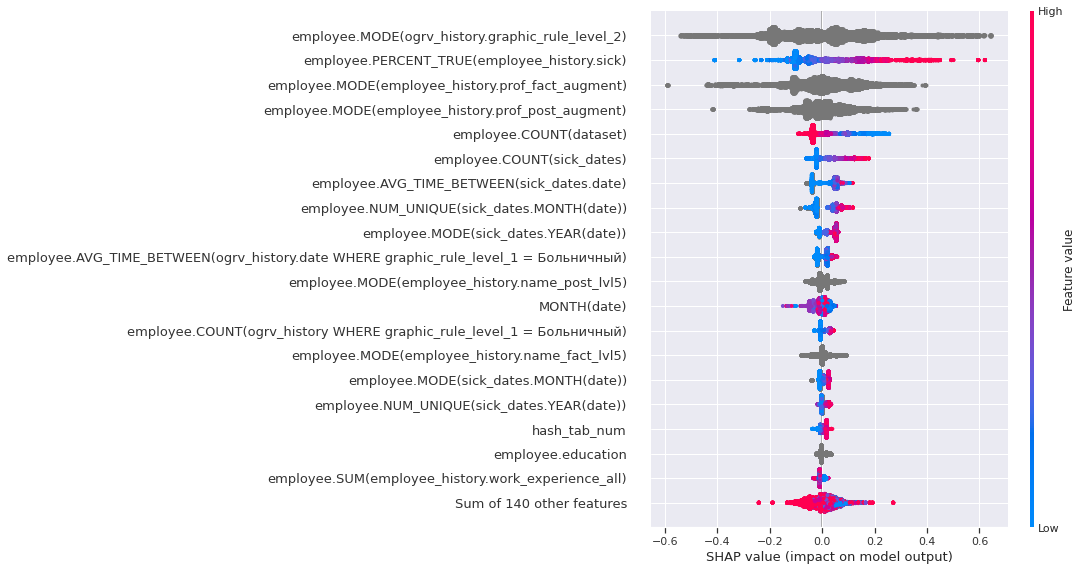

In [13]:
shap.plots.beeswarm(shap_values, max_display=20)